# Designing an optimal Coffee extraction with Python

Necessary libs:

In [1]:
import scipy.integrate as integrate
from scipy.optimize import differential_evolution
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Solving the ODE

Model data:

In [2]:
phi_h = 0.8272
k_sv1 = 27.35e-6
k_sv2 = 322.49e-6
l_l = 282e-6
D_h = D_v = 2.2e-9
m = 30e-6
c_sat = 212.4
c_s = 1400.0
kappa = 3.1
phi_c0 = 0.143435
alpha = 0.1833
beta = 0.0447
r_s = 16.94

Initial conditions:

In [3]:
c_h0 = 0.
c_v0 = 183.43
phi_v0 = 0.6444
psi_s0 = 1

EDO's system right-hand-side (RHS):

In [4]:
def coffee(t, X, alpha, beta):
    #Variables
    c_h, c_v, phi_v, psi_s = X
    
    # Coffee's desorption parameters
    desorption_1 = alpha * phi_v ** (4. / 3.) * D_v * 6. / (k_sv2 * l_l)
    desorption_2 = beta * 12. * D_h * phi_c0 / (k_sv1 * m)
    
    # Time derivatives
    # c_h
    c_h_prime = - (1. - phi_h) * desorption_1 * (c_h - c_v) + (1 - phi_h) * desorption_2 * (c_sat - c_h) * psi_s
    c_h_prime = (1. / phi_h) * c_h_prime
    # c_v
    c_v_prime = - desorption_1 * (c_h - c_v) - (c_v / c_s) * desorption_2 * (c_sat - c_h) * psi_s
    c_v_prime = (1. / phi_v) * c_v_prime
    # psi_s
    psi_s_prime = - (r_s / c_s) * desorption_2 * (c_sat - c_h) * psi_s
    # phi_v
    phi_v_prime = - (1. / r_s) * psi_s_prime
    return c_h_prime, c_v_prime, phi_v_prime, psi_s_prime

In [5]:
def coffee(t, X, alpha, beta):
    #Variables
    c_h, c_v, phi_v, psi_s = X
    
    # Coffee's desorption parameters
    desorption_1 = alpha * phi_v ** (4. / 3.) * D_v * 6. / (k_sv2 * l_l)
    desorption_2 = beta * 12. * D_h * phi_c0 / (k_sv1 * m)
    
    # Time derivatives
    # c_h
    c_h_prime = - (1. - phi_h) * desorption_1 * (c_h - c_v) + (1 - phi_h) * desorption_2 * (c_sat - c_h) * psi_s
    c_h_prime = (1. / phi_h) * c_h_prime
    # psi_s
    psi_s_prime = - (r_s / c_s) * desorption_2 * (c_sat - c_h) * psi_s
    # c_v
    c_v_prime = - desorption_1 * (c_h - c_v) + (c_v / r_s) * psi_s_prime
    c_v_prime = (1. / phi_v) * c_v_prime
    # phi_v
    phi_v_prime = - (1. / r_s) * psi_s_prime
    return c_h_prime, c_v_prime, phi_v_prime, psi_s_prime

Time step parameters:

In [6]:
t0 = 0  # tempo inicial
tmax = 600. # tempo máximo

Solving with RADAU IIA method:

In [7]:
solution_RADAU = integrate.solve_ivp(
    lambda t, X: coffee(t, X, alpha, beta), 
    t_span=(t0, tmax), 
    y0=(c_h0, c_v0, phi_v0, psi_s0,), 
    method='Radau'
)

solution_RADAU

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 2903
     njev: 95
      nlu: 552
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.78030185e-04, 1.95833204e-03, 1.97613505e-02,
       1.97791536e-01, 8.32474757e-01, 1.79121140e+00, 3.01774108e+00,
       4.24427075e+00, 5.75169475e+00, 7.25911875e+00, 8.76654275e+00,
       1.02739668e+01, 1.17813908e+01, 1.32888148e+01, 1.47962388e+01,
       1.66997044e+01, 1.86031700e+01, 2.11173370e+01, 2.43245108e+01,
       2.88107771e+01, 3.52439324e+01, 4.84456501e+01, 7.86247886e+01,
       1.04090286e+02, 1.19602111e+02, 1.25941882e+02, 1.32281654e+02,
       1.32790814e+02, 1.35798833e+02, 1.36939023e+02, 1.38800152e+02,
       1.39869523e+02, 1.41178848e+02, 1.42488173e+02, 1.43479506e+02,
       1.44470840e+02, 1.45462173e+02, 1.46453506e+02, 1.47444840e+02,
       1.48436173e+02, 1.49427507e+02, 1.50165656e+02, 1.50903806e+02,
       1.51641956e+02, 1.52079284e+0

Gathering the solutions:

In [8]:
times, variables = solution_RADAU.t, solution_RADAU.y

Separating the solutions:

In [9]:
c_h, c_v, phi_v, psi_s = variables

Plotting the solutions:

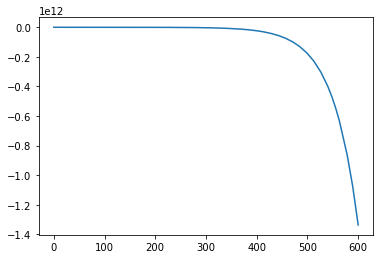

In [10]:
plt.plot(times, c_h)
plt.show()

## Calibration:

Reading the data from experimental measures:

In [11]:
exp_data = pd.read_csv('../data/coffee_conc.csv', decimal=",")

exp_data

,t,c_h
0,33.802817,29.047619
1,49.295775,31.904762
2,87.323944,34.523810
3,147.887324,36.309524
4,349.295775,36.428571
5,498.591549,36.428571


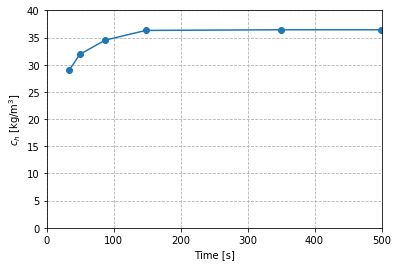

In [12]:
plt.plot(exp_data.t, exp_data.c_h, 'o-')
plt.xlabel('Time [s]')
plt.ylabel(r'$c_h$ [kg/m$^3$]')
plt.grid(True, linestyle='--')
plt.xlim([0, 500])
plt.ylim([0, 40])
plt.show()

Calibration objective function:

In [13]:
def coffee_solution(x, t_eval=[]):
    if len(x) > 2:
        raise ValueError('x must have length equal to 2: alpha and beta parameters')
        
    # Getting fitting parameters
    alpha, beta = x
    
    # Solving the ODE system
    if len(t_eval) == 0:
        raise ValueError("Please provide times to evaluate the function")
    else:
        try:
            solution_RADAU = integrate.solve_ivp(
                lambda t, X: coffee(t, X, alpha, beta), 
                t_span=(0, t_eval.max()), 
                y0=(c_h0, c_v0, phi_v0, psi_s0,), 
                method='Radau',
                t_eval=t_eval.values
            )
        except:
            return np.array([np.inf] * len(t_eval))
    
    c_h, c_v, phi_v, psi_s = solution_RADAU.y
    
    if len(c_h) != len(t_eval):
        c_h = np.array([np.inf] * len(t_eval))
    
    return c_h

In [14]:
def calibration_least_square(pars, exp_data):
    residual = exp_data.c_h.values - coffee_solution(pars, t_eval=exp_data.t)
    least_squares_evaluation = np.sum(residual ** 2.0)
    return least_squares_evaluation

Fitting by least square minimization:

In [15]:
bounds = [(0, 1), (0, 1)]
result = differential_evolution(
    calibration_least_square,
    bounds=bounds,
    args=(exp_data,),
    disp=True,
    popsize=70,
    strategy='best2exp',
    tol=1e-5,
    recombination=0.9,
    mutation=0.5,
    maxiter=50
)

/home/volps/miniconda3/envs/coffeebreak/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/volps/miniconda3/envs/coffeebreak/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:333: RuntimeWarning: invalid value encountered in less
  diff_too_small = max_diff < NUM_JAC_DIFF_REJECT * scale
/home/volps/miniconda3/envs/coffeebreak/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: invalid value encountered in less
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/volps/miniconda3/envs/coffeebreak/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: invalid value encountered in greater
  factor[max_diff > NUM_JAC_DIFF_BIG * scale] *= NUM_JAC_FACTOR_DECREASE


differential_evolution step 1: f(x)= 703.646
differential_evolution step 2: f(x)= 703.646
differential_evolution step 3: f(x)= 695.452
differential_evolution step 4: f(x)= 694.879
differential_evolution step 5: f(x)= 694.879
differential_evolution step 6: f(x)= 694.879
differential_evolution step 7: f(x)= 694.879
differential_evolution step 8: f(x)= 694.879
differential_evolution step 9: f(x)= 694.879
differential_evolution step 10: f(x)= 694.879
differential_evolution step 11: f(x)= 694.879
differential_evolution step 12: f(x)= 694.879
differential_evolution step 13: f(x)= 694.879
differential_evolution step 14: f(x)= 694.879
differential_evolution step 15: f(x)= 694.811
differential_evolution step 16: f(x)= 694.811
differential_evolution step 17: f(x)= 694.571
differential_evolution step 18: f(x)= 694.083
differential_evolution step 19: f(x)= 694.004
differential_evolution step 20: f(x)= 693.95
differential_evolution step 21: f(x)= 693.95
differential_evolution step 22: f(x)= 693.95


In [16]:
alpha, beta = result.x

alpha, beta

(0.012557390860028605, 0.022403094292317127)

In [17]:
solution_RADAU = integrate.solve_ivp(
            lambda t, X: coffee(t, X, alpha, beta), 
            t_span=(t0, tmax), 
            y0=(c_h0, c_v0, phi_v0, psi_s0,), 
            method='Radau'
        )

time = solution_RADAU.t
c_h, c_v, phi_v, psi_s = solution_RADAU.y

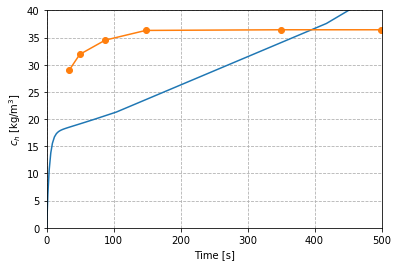

In [18]:
plt.plot(time, c_h, label='Simulated')
plt.plot(exp_data.t, exp_data.c_h, 'o-', label='Experimental')
plt.xlabel('Time [s]')
plt.ylabel(r'$c_h$ [kg/m$^3$]')
plt.grid(True, linestyle='--')
plt.xlim([0, 500])
plt.ylim([0, 40])
plt.show()

In [19]:
bounds = [(-alpha, alpha), (-beta, beta)]
result = differential_evolution(
    calibration_least_square,
    bounds=bounds,
    args=(exp_data,),
    disp=True,
    popsize=70,
    strategy='best2bin',
    tol=1e-5,
    recombination=0.9,
    mutation=0.5,
    maxiter=50
)

differential_evolution step 1: f(x)= 694.991
differential_evolution step 2: f(x)= 694.991
differential_evolution step 3: f(x)= 694.829
differential_evolution step 4: f(x)= 694.026
differential_evolution step 5: f(x)= 693.969
differential_evolution step 6: f(x)= 693.937
differential_evolution step 7: f(x)= 693.937
differential_evolution step 8: f(x)= 693.931
differential_evolution step 9: f(x)= 693.931
differential_evolution step 10: f(x)= 693.931
differential_evolution step 11: f(x)= 693.931
differential_evolution step 12: f(x)= 693.931
differential_evolution step 13: f(x)= 693.928
differential_evolution step 14: f(x)= 693.928
differential_evolution step 15: f(x)= 693.926
differential_evolution step 16: f(x)= 693.926
differential_evolution step 17: f(x)= 693.926
differential_evolution step 18: f(x)= 693.926
differential_evolution step 19: f(x)= 693.917


/home/volps/miniconda3/envs/coffeebreak/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [21]:
alpha, beta = result.x

In [22]:
solution_RADAU = integrate.solve_ivp(
            lambda t, X: coffee(t, X, alpha, beta), 
            t_span=(t0, tmax), 
            y0=(c_h0, c_v0, phi_v0, psi_s0,), 
            method='Radau'
        )

time = solution_RADAU.t
c_h, c_v, phi_v, psi_s = solution_RADAU.y

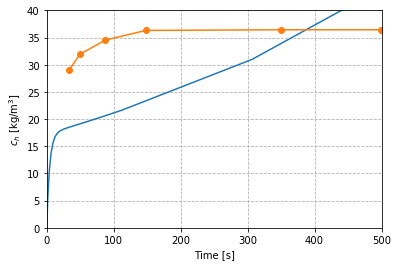

In [23]:
plt.plot(time, c_h, label='Simulated')
plt.plot(exp_data.t, exp_data.c_h, 'o-', label='Experimental')
plt.xlabel('Time [s]')
plt.ylabel(r'$c_h$ [kg/m$^3$]')
plt.grid(True, linestyle='--')
plt.xlim([0, 500])
plt.ylim([0, 40])
plt.show()